<a href="https://colab.research.google.com/github/ICT-Deeper/main/blob/main/%ED%86%B5%ED%95%A9%EC%BD%94%EB%93%9C_PGD_cifar10_both_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
# 설계팀의 코드에 nontargted, targted sample 을 둘 다 생성하는 기능을 포함한 코드
# 자세한 기능 설명은 가장 아래의 셀 참고
!pip install numpy tensorflow opencv-python-headless

In [20]:
#import the necessary packages
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import MSE
from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation, Flatten, Dropout, Dense
from google.colab.patches import cv2_imshow
from google.colab import drive
import os

In [21]:
# 저장하기 위해 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define CNN architecture

In [22]:
class SimpleCNN:
    @staticmethod
    def build(width, height, depth, classes):
        model = Sequential()
        inputShape = (height, width, depth)
        chanDim = -1

        # first CONV => RELU => BN layer set
        model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same", input_shape=inputShape))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))

        # second CONV => RELU => BN layer set
        model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same"))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chanDim))

        # first (and only) set of FC => RELU layers
        model.add(Flatten())
        model.add(Dense(128))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # softmax classifier
        model.add(Dense(classes))
        model.add(Activation("softmax"))

        return model

Define AdvSampler architecture

In [23]:
# [dataset_type] 0:cifar10, 1:cifar100
# [model_type] 0:DNN, 1:CNN
class AdvSampler():
  def __init__(self, dataset_type=0, model_type=1, name='abc', targeted=False, target_label=None):
    self.dataset_type = dataset_type
    self.model_type = model_type
    self.targeted = targeted
    self.target_label = target_label
    self.labels_cifar10 = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
    self.name = name
    self.model_path = '/content/drive/My Drive/models/'  # Update path in Google Drive
    self.Initialize()

  def Initialize(self):
    self.load_dataset()
    self.data_preprocessing()
    self.build_model()

  def load_dataset(self):
    if self.dataset_type == 0:
      print("[INFO] loading CIFAR-10 dataset...")
      (self.trainX, self.trainY), (self.testX, self.testY) = cifar10.load_data()

  def data_preprocessing(self):
    self.trainX = self.trainX / 255.0
    self.testX = self.testX / 255.0
    self.trainX = np.expand_dims(self.trainX, axis=-1)
    self.testX = np.expand_dims(self.testX, axis=-1)
    self.trainY = to_categorical(self.trainY, 10)
    self.testY = to_categorical(self.testY, 10)

  def build_model(self):
    if self.dataset_type == 0:
      self.model = SimpleCNN.build(width=32, height=32, depth=3, classes=10)

    print("[INFO] compiling model...")
    self.opt = Adam(learning_rate=1e-3)
    self.model.compile(loss='categorical_crossentropy', optimizer=self.opt, metrics=['accuracy'])

  def train_evaluate_model(self, epochs=10, batch_size=64):
      print("[INFO] training network...")
      self.model.fit(self.trainX, self.trainY, validation_data=(self.testX, self.testY), batch_size=batch_size, epochs=epochs, verbose=1)

      print("[INFO] evaluating network...")
      (loss, acc) = self.model.evaluate(x=self.testX, y=self.testY, verbose=0)
      print("[INFO] loss: {:.4f}, acc: {:.4f}".format(loss, acc))
              # Save the model to disk
      if not os.path.exists(self.model_path):
            os.makedirs(self.model_path)

      json_path = os.path.join(self.model_path, 'model.json')
      weights_path = os.path.join(self.model_path, 'model.weights.h5')

      self.save_model(json_path, weights_path)
      print("Model saved to Google Drive.")

  def save_model(self, json_path, weights_path):
        model_json = self.model.to_json()
        with open(json_path, "w") as json_file:
            json_file.write(model_json)
        self.model.save_weights(weights_path)

  def load_model(self):
        json_path = os.path.join(self.model_path, 'model.json')
        weights_path = os.path.join(self.model_path, 'model.weights.h5')

        with open(json_path, "r") as json_file:
            loaded_model_json = json_file.read()
        self.model = model_from_json(loaded_model_json)
        self.model.load_weights(weights_path)
        print("Model loaded from Google Drive.")

        self.model.compile(loss='categorical_crossentropy', optimizer=self.opt, metrics=['accuracy'])

  #PGD로 수정한 부분
  #알파 값 추가
  def generate_image_adversary(self, image, label, eps=2 / 255.0, alpha=0.01, iters=40):
      image = tf.cast(image, tf.float32)
      ori_image = image

      #반복문 추가
      for i in range(iters):
          with tf.GradientTape() as tape:
              tape.watch(image)
              pred = self.model(image)
              loss_func = tf.keras.losses.CategoricalCrossentropy()
              if self.targeted and self.target_label is not None:
                  target = to_categorical(self.target_label, 10).reshape(1, 10)
                  loss = -loss_func(target, pred)
              else:
                  loss = loss_func(label, pred)

          gradient = tape.gradient(loss, image)
          signedGrad = tf.sign(gradient)
          image = image + alpha * signedGrad

          # 클리핑을 사용해 epsilon 범위 내에 이미지 유지
          image = tf.clip_by_value(image, ori_image - eps, ori_image + eps)
          image = tf.clip_by_value(image, 0, 1)

      return image.numpy()

  def my_generator(self):
      for i in np.random.choice(np.arange(0, len(self.testX)), size=(10,)):
          image = self.testX[i]
          label = self.testY[i]
          target_label = self.target_label
          adversary = image.reshape(1, 32, 32, 3)

          # PGD를 이용해 적대적 이미지 생성
          adversary = self.generate_image_adversary(adversary, label)
          pred = self.model.predict(adversary, verbose=0)
          adversaryPred = pred[0].argmax()

          adversary = adversary.reshape((32, 32, 3)) * 255
          adversary = np.clip(adversary, 0, 255).astype("uint8")
          image = image.reshape((32, 32, 3)) * 255
          image = image.astype("uint8")

          image = cv2.resize(image, (96, 96))
          adversary = cv2.resize(adversary, (96, 96))

          imagePred = label.argmax()
          adversaryPred = pred[0].argmax()
          color = (0, 255, 0)
          if imagePred != adversaryPred:
              color = (0, 0, 255)

          cv2.putText(image, str(imagePred), (2, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.95, (0, 255, 0), 2)
          cv2.putText(adversary, str(adversaryPred), (2, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.95, color, 2)

          output = np.hstack([image, adversary])
          cv2_imshow(output)
          cv2.waitKey(0)

  def run(self):
        self.train_evaluate_model()
        self.my_generator()

Generate adversarial examples by calling AdvSampler

In [24]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[INFO] loading CIFAR-10 dataset...
[INFO] compiling model...
[INFO] training network...
Epoch 1/10
782/782 [==============================] - 6s 5ms/step - loss: 1.6247 - accuracy: 0.4421 - val_loss: 1.3250 - val_accuracy: 0.5186
Epoch 2/10
782/782 [==============================] - 4s 5ms/step - loss: 1.1928 - accuracy: 0.5746 - val_loss: 1.1429 - val_accuracy: 0.6004
Epoch 3/10
782/782 [==============================] - 4s 5ms/step - loss: 1.0432 - accuracy: 0.6301 - val_loss: 1.2640 - val_accuracy: 0.5616
Epoch 4/10
782/782 [==============================] - 4s 5ms/step - loss: 0.9434 - accuracy: 0.6663 - val_loss: 0.9959 - val_accuracy: 0.6473
Epoch 5/10
782/782 [==============================] - 4s 5ms/step - loss: 0.8776 - accuracy: 0.6938 - val_loss: 1.0110 - val_accuracy: 0.6513
Epoch 6/10
782/782 [==============================] - 4s 5ms/step - loss: 0.8083 - accuracy: 0.7148 - val_loss: 0.9763 - val_accuracy: 0.6550
Epoch 7/10
782/782 [==============================] - 4s 5ms

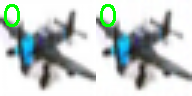

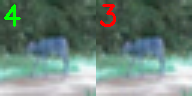

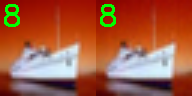

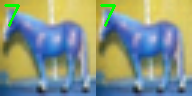

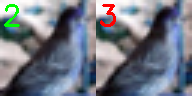

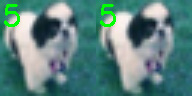

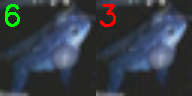

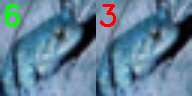

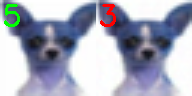

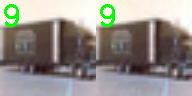

In [25]:
result = AdvSampler(name='test', targeted=True, target_label=3)
#★ result = AdvSampler(name='test', targeted=True, target_label=3) ***targted한 샘플을 생성하는 명령 (예시:target_label=3)***
#★ result = AdvSampler(name='test')  ***nontargted한 샘플을 생성하는 명령***
result.run()